# Improve Resolution with AutoEncoders

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from glob import glob

In [53]:
train_path='dataset/val'
val_path='dataset/val'

In [44]:
# Generating validation dataset
# split=0.20

# files=os.listdir(train_path)
# count=0
# for i in range(len(files)):
#     if random.random()<split:
#         file_path=os.path.join(train_path,files[i])
#         new_path=os.path.join(val_path,files[i])
#         os.rename(file_path,new_path)
#         count+=1

In [4]:
train_images = glob(os.path.join(train_path,'*'))
val_images = glob(os.path.join(val_path,'*'))

Dims: (107, 79, 3)


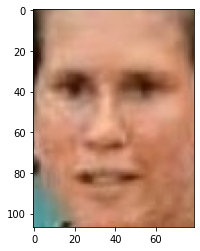

In [5]:
img_path=train_images[0]
img=cv2.imread(img_path)
print('Dims:', img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

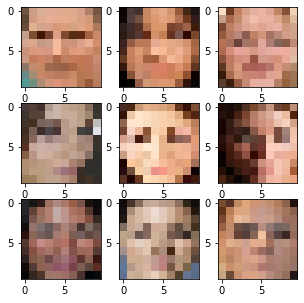

In [6]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img_path=train_images[-i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(10,10))
    plt.imshow(img)


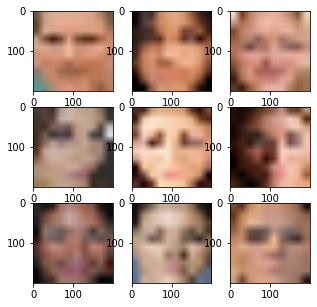

In [7]:
# Upsampling the images - using CV2

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img_path=train_images[-i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(10,10))
    img=cv2.resize(img,(200,200))
    plt.imshow(img)


# 
Reading the image from the dataset
squeezing the size to 10px - lets suppose we degrade the quality of image
then using cv2 we are trying to recover that with 200x200 image size

also comparing with the decoder doing the same operation on the image
trained on - 10x10 image and the output is the real image 

I want to see how close the neural net can go in completing the image from the latent space
this code can be used in the case where the image is squeezed due to bad image quality or other issues but we are resizing it - without using interpolation or other process.

Expectation - the image from the decoder should be more life like and real 
as compared to the cv2 form

In [45]:
# This class is a basic data loader - that is used to prepare and create
# the test train dataset - that is then fed into the network

class DataLoader:
    def __init__(self, data_dir, downsample_shape=(10,10),target_shape=(200,200)):
        self.files = self.load_files(data_dir)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.downsample_shape = downsample_shape
        self.target_shape = target_shape
    
    @staticmethod
    def load_files(root_dir):
        if not root_dir.endswith('*'):
            root_dir = os.path.join(root_dir, '*')
        return tf.data.Dataset.list_files(root_dir, shuffle=True)
    
    def process_image(self, image_path):
        img=tf.io.read_file(image_path)
        img=tf.io.decode_jpeg(img)
        
        # the input image is just 10x10 image nothing else
        input_image = tf.image.resize(img, self.downsample_shape)
        
        # we dont want them to have same shape - it will learn the
        # resizing operation, interpolation or identity from the current image
        input_image = tf.image.resize(input_image, self.target_shape)/255.
        
        # to make all the images squared - easy for neural net
        target_image = tf.image.resize(img, self.target_shape)/255.
        
        return input_image, target_image
    
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.process_image)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
#         dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset


In [46]:
test_dataset = DataLoader(train_path)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))

print('\n\n\n',' # '*10)
print(f'Input Shape: {inputs.shape}, Target Shape: {targets.shape}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'





  #  #  #  #  #  #  #  #  #  # 
Input Shape: (10, 200, 200, 3), Target Shape: (10, 200, 200, 3)


In [47]:
# Can also be set using the AUTOGRAPH_VERBOSITY environment variable
tf.autograph.set_verbosity(0)

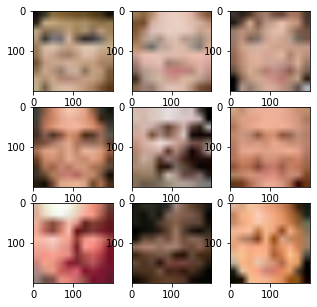

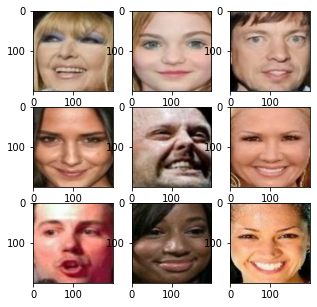

In [48]:
# Data Loader Testing 

# Inputs
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img=inputs[i]
    plt.imshow(img)

# Targets
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,1+i)
    img=targets[i]
    plt.imshow(img)

## Model Structure and Training

In [49]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, Add


In [50]:
# callbacks

early_stop_cb = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=4,
                verbose=1,
                mode='auto',
                baseline=None,
                restore_best_weights=True)

model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
                'resize_weights.h5',
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                mode='auto',
                save_freq='epoch')

reduce_lr_cb=tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=4,
                verbose=1,
                mode='auto',
                min_delta=0.0001,
                cooldown=0,
                min_lr=10e-8)

# Model Structure
input_img = Input(shape=(None,None,3))

# encoding architecture
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
# x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x3 = tf.keras.layers.MaxPool2D(padding='same')(x2)
# x4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x6 = tf.keras.layers.MaxPool2D(padding='same')(x5)
encoded = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x6)

# decoding architecture
x7 = tf.keras.layers.UpSampling2D()(encoded)
# x8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x10 = tf.keras.layers.Add()([x5, x9])
x11 = tf.keras.layers.UpSampling2D()(x10)
# x12 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x11)
x13 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x11)
x14 = tf.keras.layers.Add()([x2, x13])
decoded = tf.keras.layers.Conv2D(3, (3, 3), padding='same',activation='relu')(x14)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, None, None, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, None, None, 6 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, None, 1 73856       max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [54]:
# Hyper Parameters
batch_size=8
epochs=2
lr=0.001
downsample_shape=(10,10)
target_shape=(200,200)

opt = tf.keras.optimizers.Adam(learning_rate=lr)

autoencoder.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['mse'])

# Dataset Generator
train_dataset = DataLoader(val_path, downsample_shape=downsample_shape, target_shape=target_shape)
train_generator = train_dataset.data_generator(batch_size)

val_dataset = DataLoader(val_path, downsample_shape=downsample_shape, target_shape=target_shape)
val_generator = val_dataset.data_generator(batch_size)

# Calculate num steps
train_steps = len(list(train_dataset.files)) // batch_size + 1
val_steps = len(list(val_dataset.files)) // batch_size + 1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [28]:
# train_steps=10
# val_steps=10

In [55]:
history = autoencoder.fit(train_generator,
#                           validation_data=val_generator,
                         steps_per_epoch=train_steps,
#                          validation_steps=val_steps, 
                         epochs=epochs)
#                          callbacks=[early_stop_cb,
#                                     model_ckpt_cb,
#                                     reduce_lr_cb])

Train for 63 steps
Epoch 1/2
 1/63 [..............................] - ETA: 11:13

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-66cc1b11cbbd>", line 5, in <module>
    epochs=epochs)
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 128, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 98, in execution_function
    distributed_function(input_fn))
  File "

ResourceExhaustedError:  OOM when allocating tensor with shape[8,200,200,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_4/up_sampling2d_9/resize/ResizeNearestNeighbor (defined at <ipython-input-55-66cc1b11cbbd>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_74785]

Function call stack:
distributed_function


In [62]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [63]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32,64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -2
        
        inputs = Input(shape=inputShape)
        x = inputs
        
        for f in filters:
            x = Conv2D(f, (3,3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        encoder = Model(inputs, latent, name='encoder')
        
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3,3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        x = Conv2DTranspose(depth, (3,3), padding='same')(x)
        outputs = Activation('sigmoid')(x)
        
        decoder = Model(latentInputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)),
                           name='autoencoder')
        return (encoder, decoder, autoencoder)

In [64]:
# building the model
(encoder, decoder, autoencoder) = ConvAutoencoder.build(200, 200, 3)

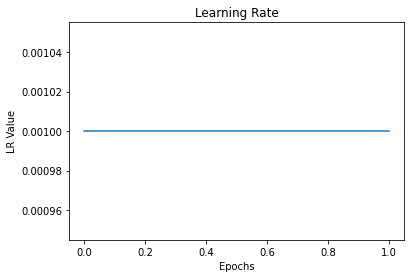

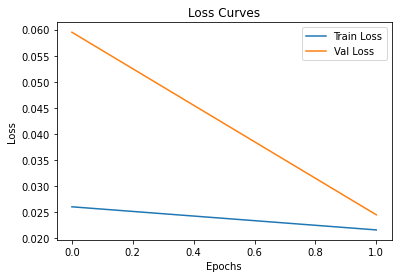

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-9f02bea1bc76>", line 20, in <module>
    plt.plot(history.history['mse'], label="Train MSE")
KeyError: 'mse'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vinay\miniconda3\envs\tf2\lib\site-packages\IPython\core\ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Vinay\m

KeyError: 'mse'

In [74]:
# Matplotlib Plots (For Easy Rendering)

# Learning Rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel("Epochs")
plt.ylabel("LR Value")
plt.show()

# Loss Curves
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Curves')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# MSE Curves
plt.plot(history.history['mse'], label="Train MSE")
plt.plot(history.history['val_mse'], label="Val MSE")
plt.title('MSE Curves')
plt.xlabel("Epochs")
plt.ylabel("MSe")
plt.legend()
plt.show()

In [65]:
opt = Adam(lr=1e-3)
autoencoder.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
# categorical_crossentropy
# binary_crossentropy
# mse

In [67]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 16)                2580008   
_________________________________________________________________
decoder (Model)              (None, 200, 200, 3)       2777459   
Total params: 5,357,467
Trainable params: 5,356,567
Non-trainable params: 900
_________________________________________________________________


In [79]:
epochs=10
history = autoencoder.fit(train_generator,
                          validation_data=val_generator,
                         steps_per_epoch=train_steps,
                         validation_steps=val_steps, 
                         epochs=epochs,
                         callbacks=[early_stop_cb,
                                    model_ckpt_cb,
                                    reduce_lr_cb])

Train for 63 steps, validate for 63 steps
Epoch 1/10
63/63 [==============================] - 6s 92ms/step - loss: 0.0198 - accuracy: 0.9684 - val_loss: 0.0228 - val_accuracy: 0.9714
Epoch 2/10
63/63 [==============================] - 5s 86ms/step - loss: 0.0191 - accuracy: 0.9701 - val_loss: 0.0180 - val_accuracy: 0.9709
Epoch 3/10
63/63 [==============================] - 5s 84ms/step - loss: 0.0183 - accuracy: 0.9705 - val_loss: 0.0170 - val_accuracy: 0.9715
Epoch 4/10
63/63 [==============================] - 5s 87ms/step - loss: 0.0175 - accuracy: 0.9695 - val_loss: 0.0155 - val_accuracy: 0.9690
Epoch 5/10
63/63 [==============================] - 5s 84ms/step - loss: 0.0168 - accuracy: 0.9696 - val_loss: 0.0146 - val_accuracy: 0.9707
Epoch 6/10
63/63 [==============================] - 5s 75ms/step - loss: 0.0161 - accuracy: 0.9688 - val_loss: 0.0158 - val_accuracy: 0.9680
Epoch 7/10
63/63 [==============================] - 5s 75ms/step - loss: 0.0157 - accuracy: 0.9678 - val_loss: 0

In [70]:
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(inputs)

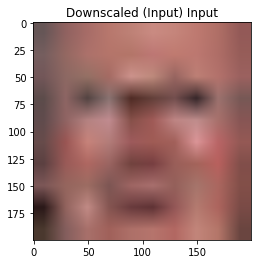

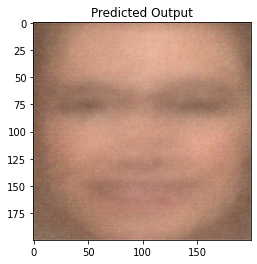

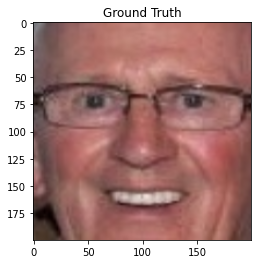

In [73]:
index = 2
plt.imshow(inputs[index], cmap="gray")
plt.title("Downscaled (Input) Input")
plt.show()
plt.imshow(preds[index] / tf.math.reduce_max(preds[index]), cmap="gray")
plt.title("Predicted Output")
plt.show()
plt.imshow(targets[index], cmap="gray")
plt.title("Ground Truth")
plt.show()

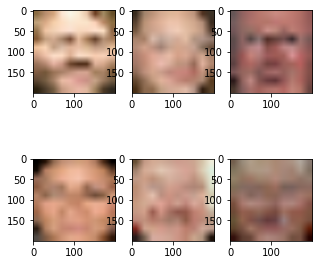

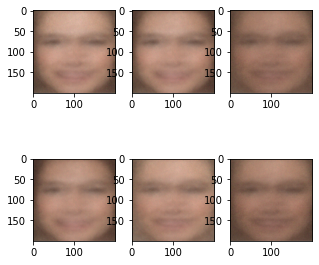

In [78]:
# Data Loader Testing 

# Targets
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=inputs[i]
    plt.imshow(img)
    
# Inputs
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=preds[i]
    plt.imshow(img)



In [83]:
# After 10 epoch more

In [80]:
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(inputs)

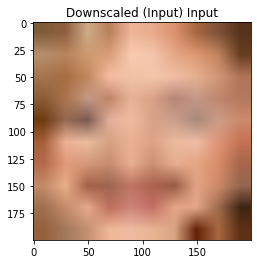

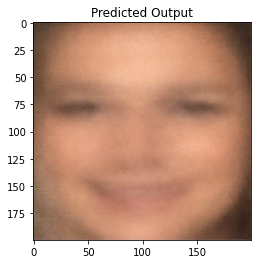

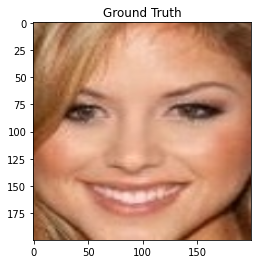

In [81]:
index = 2
plt.imshow(inputs[index], cmap="gray")
plt.title("Downscaled (Input) Input")
plt.show()
plt.imshow(preds[index] / tf.math.reduce_max(preds[index]), cmap="gray")
plt.title("Predicted Output")
plt.show()
plt.imshow(targets[index], cmap="gray")
plt.title("Ground Truth")
plt.show()

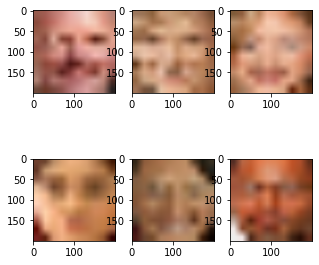

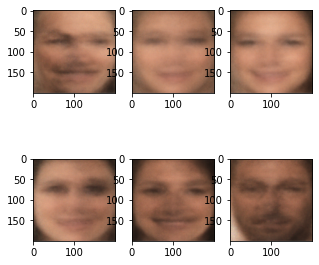

In [82]:
# Data Loader Testing 

# Targets
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=inputs[i]
    plt.imshow(img)
    
# Inputs
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=preds[i]
    plt.imshow(img)


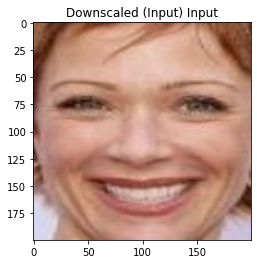

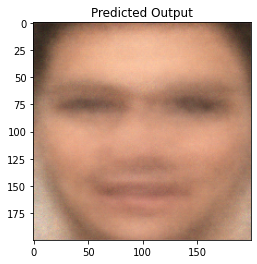

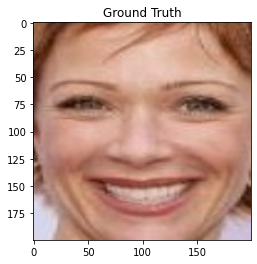

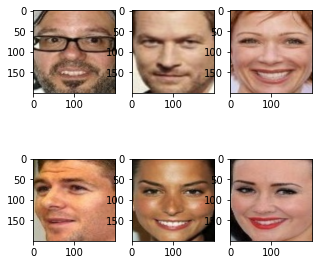

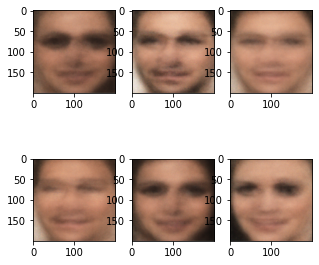

In [86]:
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(targets)

index = 2
plt.imshow(targets[index], cmap="gray")
plt.title("Downscaled (Input) Input")
plt.show()
plt.imshow(preds[index] / tf.math.reduce_max(preds[index]), cmap="gray")
plt.title("Predicted Output")
plt.show()
plt.imshow(targets[index], cmap="gray")
plt.title("Ground Truth")
plt.show()

# Data Loader Testing 

# Targets
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=targets[i]
    plt.imshow(img)
    
# Inputs
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,1+i)
    img=preds[i]
    plt.imshow(img)